In [1]:
import json, os
import pandas as pd

from tqdm import tqdm
import re, matplotlib, shutil, string, random, datetime, time
import numpy as np

import tweepy
from tweepy import OAuthHandler


import random
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import urllib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import seaborn as sns
from collections import Counter

%matplotlib inline

In [43]:
import pandas as pd
edges = pd.read_csv('D:\\script\\BL\\edges_intermoda.csv')[['source','target']]

In [44]:
edges['source'] = edges['source'].transform(lambda s:' '.join(s.split()))
edges['target'] = edges['target'].transform(lambda s:' '.join(s.split()))

In [46]:
#outdegree
out_degree = edges[['source']].groupby('source').size().reset_index().rename(columns = {0:'out_degree'})
in_degree = edges[['target']].groupby('target').size().reset_index().rename(columns = {0:'in_degree'})
nodes = edges.merge(out_degree,on='source').merge(in_degree,on='target')

In [50]:
nodes = in_degree.rename(columns={'target':'id'}).merge(out_degree.rename(columns={'source':'id'}), how='outer').fillna(0)
nodes['label'] = nodes['id']
nodes['degree'] = nodes['in_degree']+nodes['out_degree']

In [56]:
nodes.shape

(705, 5)

In [58]:
edges = edges.drop_duplicates()
edges.shape

(6097, 2)

In [59]:
edges.to_csv('D:\\script\\BL\\fix_edges.csv', index=False)
nodes.to_csv('D:\\script\\BL\\fix_nodes.csv', index=False)

In [19]:
len(edges.source.unique())

17

# dummy

In [22]:
sample_edges = edges.sample(100)

In [23]:
nodes_sample = set(sample_edges['source'].unique())|set(sample_edges['target'].unique())
nodes_sample = pd.DataFrame(nodes_sample,columns=['id'])
nodes_sample['label'] = nodes_sample['id']
nodes_sample['label'][0]

'GATE 20 B -TEB'

In [26]:
import re
nodes_sample['size'] = nodes_sample['label'].transform(lambda s: int(re.findall('\d+',s)[0]))

In [29]:
nodes_sample.to_csv('D:\\script\\BL\\contoh_nodes.csv')
sample_edges.to_csv('D:\\script\\BL\\contoh_edges.csv')

# prepare data

In [2]:
CONSUMER_KEY = 'XXXXX'
CONSUMER_SECRET = 'XXXXXXXXX'
ACCESS_KEY = 'XXXXXXXXXXXXX'
ACCESS_SECRET = 'XXXXXXXXXXXXXXXX'
auth = OAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
api = tweepy.API(auth)
auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
#search
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True) 

==== fachrul k ***


In [ ]:
#remove keys of user
list_pop_user=['profile_background_color', 'notifications',  'geo_enabled', 
               'follow_request_sent', 'profile_use_background_image', 'default_profile_image',
               'following', 'profile_link_color',  'has_extended_profile', 'default_profile',
               'contributors_enabled', 'profile_text_color', 'profile_background_image_url','entities',
               'profile_sidebar_border_color', 'profile_background_image_url_https','time_zone',
               'is_translator', 'id', 'translator_type', 'profile_banner_url', 'profile_background_tile',
               'is_translation_enabled', 'profile_image_url_https', 'profile_sidebar_fill_color','utc_offset','lang']

In [10]:
username = 'bukalapak'
startDate = datetime.datetime(2020, 9, 3, 0, 0, 0)
endDate =   datetime.datetime(2020, 9, 13, 0, 0, 0)

tweets = []
tmpTweets = api.user_timeline(username)
for tweet in tmpTweets:
    if tweet.created_at < endDate and tweet.created_at > startDate:
        tweets.append(tweet)

while (tmpTweets[-1].created_at > startDate):
    tmpTweets = api.user_timeline(username, max_id = tmpTweets[-1].id)
    for tweet in tmpTweets:
        if tweet.created_at < endDate and tweet.created_at > startDate:
            tweets.append(tweet)

In [17]:
data_tweets = []
for tw in tweets:
    tw = tw._json
    for pop in list_pop_user:
        tw['user'].pop(pop,None)
    data_tweets.append(tw)

In [23]:
timeline = []
for tw in data_bukalapak:
    tw = tw._json
    for pop in list_pop_user:
        tw['user'].pop(pop,None)
    timeline.append(tw)   

In [31]:
q="bukalapak since:2020-09-03 until:2020-09-13"
timeline = []
for tw in tweepy.Cursor(api.search,q=q,count=100).items():
    tw = tw._json
    for pop in list_pop_user:
        tw['user'].pop(pop,None)
    timeline.append(tw)   
    print(len(timeline),end='\r')

# social scoring

In [33]:
class scoring:
    def interpolasi(self,X, kind):
        index=True
        if kind=='retweet':
            if X<102:
                x=[0,49,97.2,101]
                y=[0,17.5,26.2,26.6]
            elif X<200:
                x=[101,188.4,207,258.7]
                y=[26.6,32.6,33.1,34.1]
            elif X<536:
                x=[188.4,207,258.7,536]
                y=[32.6,33.1,34.1,35]
            else:
                Y=35
                index=False

        elif kind=='like':
            if X<52:
                x=[0,13.6,29.5,52.6]
                y=[0,1.1,2.2,3.6]
            elif X<82:
                y=[3.6,4.1,4.8,5]
                x=[52.6,62.7,76.4,82]
            elif X<140:
                x=[82,130.9,142,146.6]
                y=[5,6.7,7,7.1]

            elif X<210:
                x=[142,146.6,162.1,216.6]
                y=[7,7.1,7.5,8.4]

            elif X<300:
                x=[162.1,216.6,282.9,323.8]
                y=[7.5,8.4,9.1,9.4]

            elif X<600:
                x=[323.8,394.7,429.4,600]
                y=[9.4,9.6,9.7,9.9]

            else:
                Y=10
                index=False

        elif kind=='follower':
            if X<600:
                x=[0,205,484,573]
                y=[0,0.7,1.5,1.8]
            elif X<1000:
                x=[622,700,800,945]
                y=[1.9,2.3,2.7,2.9]
            elif X<2600:
                x=[1195,1370,2358,2557]
                y=[3.6,4.1,6.8,7.3]
            elif X<4000:
                x=[2700,3000,3500,4000]
                y=[7.5,8.1,9.2,11]
            elif X<9100:
                x=[4500,5555,7526,9070]
                y=[12,14,17.5,19.8]
            elif X<82526:
                x=[20094,21935,35129,82526]
                y=[29.5,30.4,33.6,35]
            else:
                Y=35
                index=False
        elif kind=='list':
            if X<827:
                x=[0,223,598,826]
                y=[0,0.9,2.2,3]
            elif X<1215:
                x=[826,979,1069,1214]
                y=[3,3.4,3.7,4]
            elif X<1739:
                x=[1214,1272,1630,1738]
                y=[4,4.2,5,5.2]
            elif X<2423:
                x=[1738,1880,2002,2422]
                y=[5.2,5.5,6,6.4]
            elif X<2997:
                x=[2422,2500,2750,2996]
                y=[6.4,6.7,7,7.2]
            elif X<4790:
                x=[2996,3936,4254,4789]
                y=[7.2,8.1,8.4,8.7]
            elif X<16801:
                x=[4789,5382,8927,16800]
                y=[8.7,9,9.8,10]
            else:
                Y=10
                index=False

        if index==True:
            L0=(X-x[1])/(x[0]-x[1])*(X-x[2])/(x[0]-x[2])*(X-x[3])/(x[0]-x[3])*y[0]
            L1=(X-x[0])/(x[1]-x[0])*(X-x[2])/(x[1]-x[2])*(X-x[3])/(x[1]-x[3])*y[1]
            L2=(X-x[0])/(x[2]-x[0])*(X-x[1])/(x[2]-x[1])*(X-x[3])/(x[2]-x[3])*y[2]
            L3=(X-x[0])/(x[3]-x[0])*(X-x[1])/(x[3]-x[1])*(X-x[2])/(x[3]-x[2])*y[3]

            Y=L1+L0+L2+L3

        return Y
    def result_SA(self, retweet,like,follower,list_,verified):
        if verified==True:
            ver=10
        else:
            ver=0
        SA=self.interpolasi(retweet,'retweet')+self.interpolasi(like,'like')+self.interpolasi(follower,'follower')+self.interpolasi(list_,'list')+ver
        return SA
    def call_SA(self,df):
        rt=list(result['total_shares']/result['total_posts'])[0]
        lk=list(result['total_likes']/result['total_posts'])[0]
        ls=list(result['list_count']/result['total_posts'])[0]
        fl=result['fan_count'][0]
        return self.result_SA(rt,lk,fl,ls,df['verified'][0])


In [34]:
df_bl = pd.DataFrame(data_tweets)

In [54]:
mean_count = df_bl[['retweet_count','favorite_count']].mean()
data_this_day = df_bl.sort_values('created_at')[-1:]['user'].values[0]

True

In [65]:
scoring_bl = scoring().result_SA(mean_count['retweet_count'],
                                 mean_count['favorite_count'],
                                 data_this_day['followers_count'],
                                 data_this_day['listed_count'],
                                 data_this_day['verified'])

In [85]:
def gauge_performance_index(score, color):
#     score = int(score)
    fig, ax = plt.subplots(figsize=(3,3))
    ax.pie(x=[100-score,score], wedgeprops=dict(width=0.25), startangle=90, colors=['#f6f6f6',color])
    ax.annotate('{:.3}'.format(score), (.5,.5), fontsize=30, xycoords='axes fraction', weight='bold',
                horizontalalignment='center', verticalalignment='center',
                fontname='Calibri')
    title = 'Bukalapak\nPerformance Index'
    plt.title(title, fontsize=12, fontname='Arial', y=.95)
    title = title.replace('\n',' ')
    plt.show()
    


findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


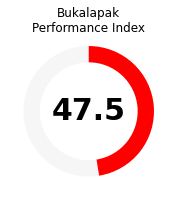

In [86]:
gauge_performance_index(scoring_bl,'r')

# engagement

In [98]:
df_bl['user_id_str'] = df_bl['user'].transform(lambda x: x.get('id_str',x.get('id')))
df_bl['username'] = df_bl['user'].transform(lambda x: x['screen_name'])
df_bl['followers'] = df_bl['user'].transform(lambda x: x['followers_count'])
df_bl['listed_on'] = df_bl['user'].transform(lambda x: x['listed_count'])
df_bl['verified'] = df_bl['user'].transform(lambda x: x['verified'])
df_bl['post'] = 1

'datetime_ms'


In [104]:
df_bl['created_time'] = df_bl.created_at.transform(lambda x: pd.Timestamp(x, tz='UTC').tz_convert('Asia/Jakarta'))
df_bl['Engagement'] = df_bl['retweet_count']*.6+df_bl['favorite_count']*.4
df_bl['count']=1

In [109]:
def trend_post_engagement(data, types='D'):
    
    total_post = data.groupby(pd.Grouper(key='created_time',freq=types)).sum()[['count']]
    mean_EE = data.groupby(pd.Grouper(key='created_time',freq=types)).mean()[['Engagement']]

    a = pd.concat([total_post,mean_EE], axis=1).fillna(0)
   
    a.columns = ["Total Posts","Avg. Engagement Score"]
    x1 = a.index
    x2 = x1.map(datetime.datetime.toordinal)
    y1 = a["Avg. Engagement Score"]
    z = np.polyfit(x2,y1,1)
    p = np.poly1d(z)

    a = a.reset_index()
    if types == "D":
        a["created_time"] = a["created_time"].apply(lambda x:datetime.datetime.strftime(x, "%d %b %Y"))
        title = 'Daily Engagement'
    elif types == "MS":
        a["created_time"] = a["created_time"].apply(lambda x:datetime.datetime.strftime(x, "%b-%Y"))
        title = 'Monthly Engagement'
    else :
        title = ''
    a = a.set_index("created_time")
    a["Mean"] = a["Avg. Engagement Score"].mean()
    a['Linear (Avg. Engagement Score)'] = p(x2)

    b = a[["Avg. Engagement Score","Mean",'Linear (Avg. Engagement Score)']]
    fig,ax=plt.subplots(figsize=(15,6))
    ax2 = ax.twinx()
    a.plot(kind="line", y="Avg. Engagement Score", ax=ax2, linewidth=3, color="#E21F29", 
           marker='o')
    a.plot(kind="bar",y="Total Posts" ,ax=ax, color="#48c934")
    a.plot(kind="line", y="Mean", ax=ax2, linewidth=3, linestyle="--", color="#f2f402")
    a.plot(kind='line', y='Linear (Avg. Engagement Score)', ax=ax2, linestyle=':', color='orange', linewidth=3, 
           ylim=(0,max(b.max())+max(b.max())*0.25))
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax2.set_ylabel('Avg. Engagement Score')
    ax.set_xticklabels(a.index,rotation = 45)
    for loc in ['top','left','bottom','right']:
        ax.spines[loc].set_color('dimgrey')
        ax2.spines[loc].set_color('dimgrey')
    xlim = ax.get_xlim()
    ax.set_xlim([xlim[0]-0.5,xlim[1]+0.5])

    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ax.legend(bbox_to_anchor=(0.83,1.1), ncol=3, frameon=False)
    ax2.legend(bbox_to_anchor=(0.7,1.1), ncol=4, frameon=False)
    plt.suptitle(title, size=18, y=1)

/home/bigdome1/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


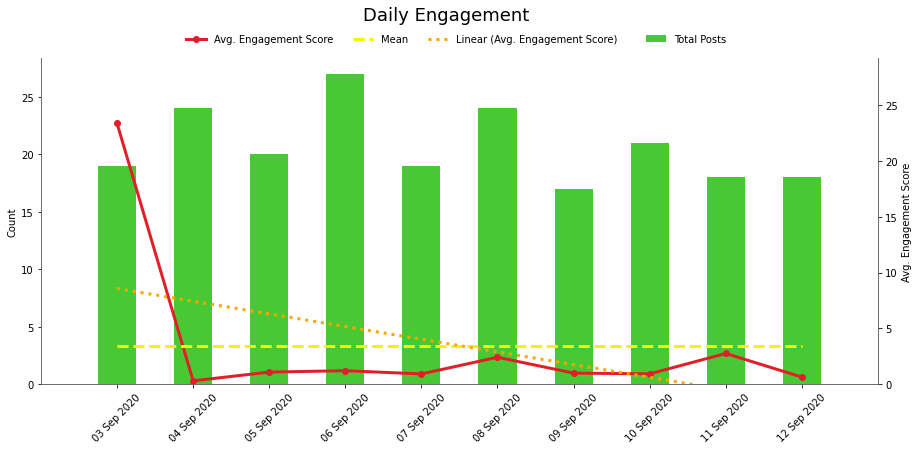

In [110]:
trend_post_engagement(df_bl)

# activities

In [111]:
def set_time(data):
    data['created_time'] = pd.to_datetime(data['created_at'])
    data['day'] = data['created_time'].apply(lambda x:x.strftime('%A'))
    data['hour'] = data['created_time'].apply(lambda x:x.hour)
    ua=data.groupby(['day','hour']).size()

    hari=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    jam=list(range(24))

    hasil3=np.zeros((7,24),dtype=int)
    for i in range(7):
        for j in jam:
            try:
                hasil3[i,j]=ua[hari[i],j]
            except:
                pass
    return hasil3
def created_time_heatmap(brand_name, data, colors):
#     data = data[data.targe_name==brand_name].reset_index(drop=True)
    plt.figure(figsize=(13,6))
    hari=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    jam=list(range(24))
    ax = sns.heatmap(pd.DataFrame(set_time(data),index=hari),cmap=colors, linewidths=.5, 
                     cbar_kws={"shrink": .54, "pad":.01}, square=True,cbar=False)
    labels = []
    for i in jam:
        if i>=10:
            if i==12:
                labels.append(str(i)+"pm")
            elif i>12:
                labels.append(str(i-12)+"pm")
            else:
                labels.append(str(i)+"am")
        else:
            if i==0:
                labels.append('12am')
            else:
                labels.append(str(i)+"am")

    ax.set_xticklabels(labels,rotation=30)
    ax.set_title("%s\n"% brand_name.title(), size=16)

    plt.show()

In [413]:
df = pd.DataFrame(timeline)
df.head()

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorite_count,favorited,retweeted,lang,extended_entities,possibly_sensitive,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Sat Sep 12 23:45:49 +0000 2020,1304929238177333248,1304929238177333248,@bukalapak Sama nih pencairan biasanya cepet s...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'in', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.304691e+18,1304691219742613504,...,0,False,False,in,NaN,NaN,NaN,NaN,NaN,NaN
1,Sat Sep 12 23:43:00 +0000 2020,1304928529566412801,1304928529566412801,POLOSE juga bisa kalian dapatkan melalui akun ...,False,"{'hashtags': [{'text': 'kaospolos', 'indices':...","{'iso_language_code': 'in', 'result_type': 're...","<a href=""http://twittbot.net/"" rel=""nofollow"">...",NaN,None,...,0,False,False,in,NaN,NaN,NaN,NaN,NaN,NaN
2,Sat Sep 12 23:34:27 +0000 2020,1304926376496001024,1304926376496001024,Agaricpro Obat Penyakit Paru-Paru Paling Aman ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'in', 'result_type': 're...","<a href=""http://twittbot.net/"" rel=""nofollow"">...",NaN,None,...,0,False,False,in,"{'media': [{'id': 865059906180624384, 'id_str'...",False,NaN,NaN,NaN,NaN
3,Sat Sep 12 23:09:15 +0000 2020,1304920034578399236,1304920034578399236,HARGA : 75k (diluar ongkir)\n\nTOPVALU\n\nKond...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'in', 'result_type': 're...","<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,None,...,0,False,False,in,NaN,False,NaN,NaN,NaN,NaN
4,Sat Sep 12 23:08:56 +0000 2020,1304919956325195776,1304919956325195776,@firlysavitri @ShopeeID Tokopedia and Bukalapa...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'tl', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.304695e+18,1304694693444288512,...,0,False,False,tl,NaN,NaN,NaN,NaN,NaN,NaN


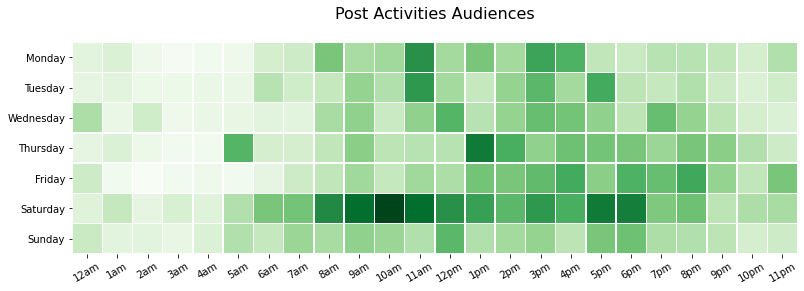

In [428]:
from dateutil import tz
df = pd.DataFrame(timeline)
df['created_at'] = df['created_at'].transform(lambda s: pd.Timestamp(s,tzinfo=tz.tzlocal()))
created_time_heatmap('Post Activities Audiences',df,'Greens')
plt.show()

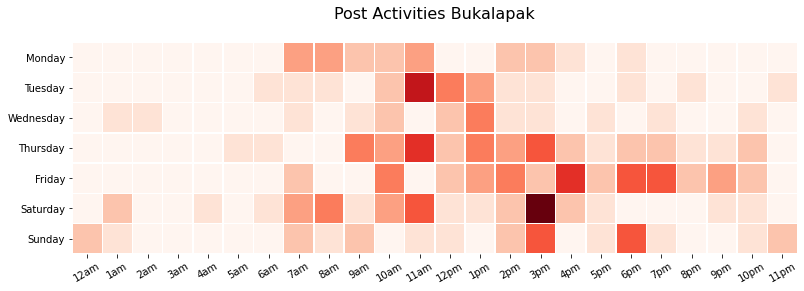

In [429]:
df_bl['created_at'] = df_bl['created_at'].transform(lambda s: pd.Timestamp(s,tzinfo=tz.tzlocal()))
created_time_heatmap('Post Activities Bukalapak',df_bl,'Reds')
plt.show()

# post

In [279]:
def type_of_tweet(i):
    if i.get('quoted_status',None)!=None:
        type_post = 'quote'
    elif i.get('in_reply_to_status_id_str',None)!=None:
        type_post = 'reply'
    elif i.get('retweeted_status',None)!=None:
        type_post = 'retweet'
    else:
        type_post = 'tweet'
    return type_post
def donut_chart(df, kind,colors=None):
    if colors:
        c = []
        for i in df.index:
            for k, v in colors.items():
                if i == k:
                    c.append(v)
                    break
        colors = c
    fig, ax = plt.subplots(figsize=(5,5))
    wedges, texts = ax.pie(df['count'], wedgeprops=dict(width=0.4), startangle=-10, colors=colors)
    for i, p in enumerate(wedges):
        if colors:
            bbox_props = dict(boxstyle="round,pad=0.2", fc=colors[i], ec="k", lw=0.7, alpha=.3)
        else:
            bbox_props = dict(boxstyle="round,pad=0.2",  ec="k", lw=0.7, alpha=.3)
        kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-", color='k'),
                  bbox=bbox_props, zorder=0, va="center")
        ang = (p.theta2 - p.theta1)/2 + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        connectionstyle = "angle, angleA=0, angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        percent = 100*df['count'][i]/sum(df.sum())
        percs = '{:.1f}'.format(percent).replace('.',',')
        ax.annotate('{}\n{}%'.format(df.index[i].title(), percs), xy=(x, y), xytext=(1.4*np.sign(x), 1.1*y),
                     ha='center', fontsize=11, **kw)

    plt.title('{} Proportion'.format(kind.title()), fontsize=20, color='k')
    
def engagement_vs(df, colors,kind, title = 'Engagement per Sentiment'):
#     data = df.groupby(kind).mean()[['Engagement']].sort_values('Engagement',ascending=True)
    data = df
    my_color = [list(matplotlib.colors.to_rgba(colors[i])) for i in data.index]
    fig,ax=plt.subplots(figsize=(6,5))
    data[['Engagement']].plot(kind='barh', width=.75, legend=False,ax=ax, color=[np.array(my_color)])
    ax.set_ylabel('')
    for i in ax.spines:
        ax.spines[i].set_visible(False)
    ax.set_xticks([])
    yloc = len(data)-1.07
    for value in list(data.sort_values('Engagement',ascending=False)['Engagement']):
        if value != 0:
            if value >= 1000:
                va = "  {:.3f}".format(value/1000)
            else:
                va = "  {:.2f}".format(value)

            xloc = value+0.01*value
            ax.annotate(s='{}'.format(str(va)), 
                        xy=(xloc,yloc), 
                        xycoords=('data', 'data'), 
                        color='k',size=11)
        yloc-=1
    plt.title(title, size=14)

In [170]:
df_bl['type_of_post'] = df_bl.apply(type_of_tweet,axis=1)

,count
type_of_post,
reply,145.0
tweet,62.0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


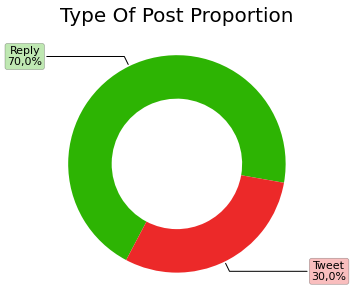

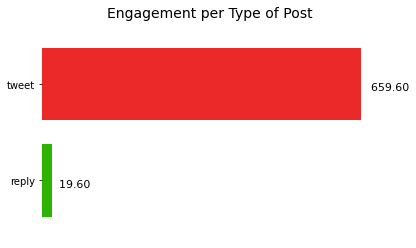

In [275]:
pt = df_bl.groupby('type_of_post').sum()[['count']]
display(pt)
colors = {'tweet':'#ec2929',
          'reply':'#2db403',
          'quote':'#f6ec04',
          'retweet':'#ab04f6'}
donut_chart(pt,'type of post', colors=colors)
pt = df_bl.groupby('type_of_post').sum()[['Engagement']]
engagement_vs(pt,colors, kind='type_of_post', title='Engagement per Type of Post')

,count
kind,
reply-photo,8.0
reply-text,137.0
tweet-photo,1.0
tweet-text,61.0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


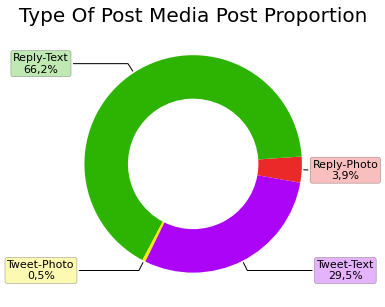

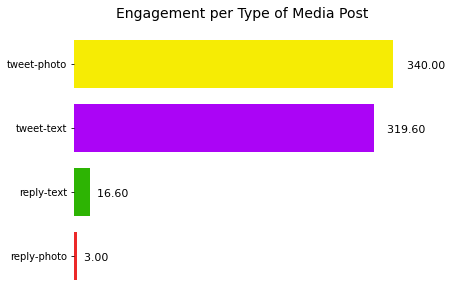

In [283]:
pt = df_bl.groupby(['type_of_post','media']).sum()[['count']]
pt = pt.reset_index()
pt['kind'] = pt.apply(lambda s: '{}-{}'.format(s['type_of_post'],s['media']),axis=1)
pt = pt[['kind','count']].set_index('kind')
display(pt)
colors = {'reply-photo':'#ec2929',
          'reply-text':'#2db403',
          'tweet-photo':'#f6ec04',
          'tweet-text':'#ab04f6'}
donut_chart(pt,'type of post media post', colors=colors)


pt = df_bl.groupby(['type_of_post','media']).sum()[['Engagement']]
pt = pt.reset_index()
pt['kind'] = pt.apply(lambda s: '{}-{}'.format(s['type_of_post'],s['media']),axis=1)
pt = pt[['kind','Engagement']].set_index('kind')
engagement_vs(pt.sort_values('Engagement'),colors, kind='media', title='Engagement per Type of Media Post')

# influencers

In [133]:
df = pd.DataFrame(timeline)

df['user_id_str'] = df['user'].transform(lambda x: x.get('id_str',x.get('id')))
df['username'] = df['user'].transform(lambda x: x['screen_name'])
df = df[df['username']!=df_bl['username'][0]] #menghapus data dari bukalapak
df['followers'] = df['user'].transform(lambda x: x['followers_count'])
df['listed_on'] = df['user'].transform(lambda x: x['listed_count'])
df['verified'] = df['user'].transform(lambda x: x['verified'])
df['post'] = 1
df['count'] = 1

In [134]:
user = df.groupby(['user_id_str','username','verified']).agg({'favorite_count':'mean','retweet_count':'mean',
                                          'post':'sum','followers':'mean','listed_on':'mean'}).reset_index()

user['quality_of_post'] = user.apply(lambda x: scoring().interpolasi(x['retweet_count'],'retweet')+
                                     scoring().interpolasi(x['favorite_count'],'like')/x['post']*10, axis=1)

user['social_scoring'] = user.apply(lambda x: scoring().result_SA(x['retweet_count'],x['favorite_count'],x['followers'],x['listed_on'],x['verified']), axis=1)

df['created_time'] = df.created_at.transform(lambda x: pd.Timestamp(x, tz='UTC').tz_convert('Asia/Jakarta'))
df['Engagement'] = df['retweet_count']*.6+df['favorite_count']*.4

,created_time,count,Engagement
0,2020-09-13 06:45:49+07:00,1,0.0
1,2020-09-13 06:43:00+07:00,1,0.0


/home/bigdome1/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


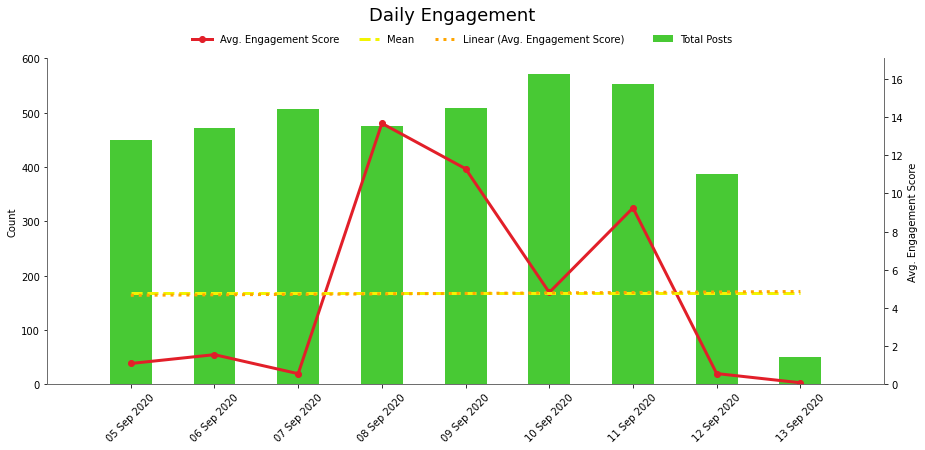

In [135]:
display(df[['created_time','count','Engagement']].head(2))
c = trend_post_engagement(df,types='D')

In [136]:
popular = user[user['social_scoring']>50]
non_popular = user[user['social_scoring']<=50]

In [137]:
def barchart_account(dt,kind, title=None):
    dt = dt.sort_values(kind, ascending=True).set_index('username')
    fig,ax=plt.subplots(figsize=(4,4))

    colors = [list(matplotlib.colors.to_rgba(i)) for i in ['#ec2929','#2db403','#800000','#404040','#376092']]
    dt[[kind]].plot(kind='barh', width=.75, legend=False,ax=ax,color=[np.array(colors)])
    ax.set_ylabel('')
    for i in ax.spines:
        ax.spines[i].set_visible(False)
    ax.set_xticks([])
    yloc = len(dt)-1.07
    for value in list(dt.sort_values(kind,ascending=False)[kind]):
        if value != 0:
            if value >= 1000:
                va = "  {:.3f}".format(value/1000)
            else:
                va = "  {:.2f}".format(value)

            xloc = value+0.01*value
            ax.annotate(s='{}'.format(str(va)), 
                        xy=(xloc,yloc), 
                        xycoords=('data', 'data'), 
                        color='k',size=11)
        yloc-=1
    plt.title(title, size=14)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


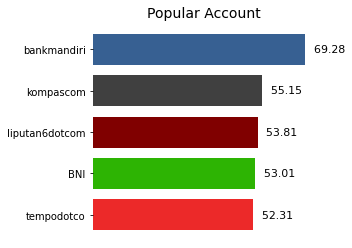

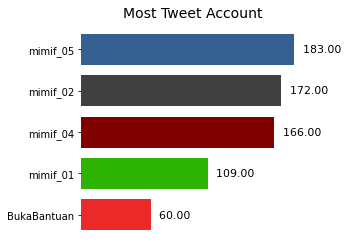

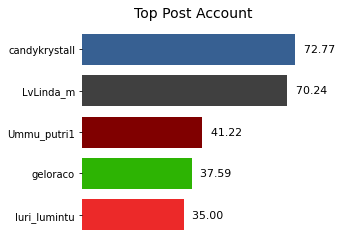

In [138]:
barchart_account(user.sort_values('social_scoring', ascending=False).head(5),'social_scoring','Popular Account')
barchart_account(user.sort_values('post', ascending=False).head(5),'post','Most Tweet Account')
barchart_account(user.sort_values('quality_of_post', ascending=False).head(5),'quality_of_post','Top Post Account')

# network

In [287]:
len(tweets), len(timeline)

(207, 4128)

In [301]:
df_net = pd.DataFrame([i._json for i in tweets]+timeline)
df_net = df_net.drop_duplicates('id')

In [411]:
import re
edges = []
nodes = set()
all_text = []
for _,i in tqdm(df_net.iterrows()):
    text = i['text']
    username = i['user']['screen_name']
    #ambil semua hashtag
    hashtag = re.findall(r'(?<!\w)(?:#?)(#\w+)(?:\s+|$)',text)
    #ambil semua mention
    mention = re.findall('@(\w+)', text)
    link = 'https://twitter.com/{}/status/{}'.format(username,i['id_str'])
    for hg in hashtag:
        edges.append({'source':username,'target':hg.lower(),'kind':'hashtag','text':i['text'],'link':link})
        nodes.update([hg.lower()])
    for mt in hashtag:
        edges.append({'source':username,'target':mt,'kind':'mention','text':i['text']})
        nodes.update([mt])
    nodes.update([username])
    all_text.append(text)
        
len(all_text)

4170it [00:00, 5288.47it/s]


583

In [332]:
pd.DataFrame(edges).to_csv('edges.csv', index=False)
nodes = pd.DataFrame(nodes).rename(columns={0:'id'})
nodes['label'] = nodes['id']
nodes.to_csv('nodes.csv', index=False)

# semantic analysis

In [341]:
import json, pandas as pd, os, matplotlib, matplotlib.pyplot as plt, numpy as np
%matplotlib inline
from tqdm import tqdm
from datetime import datetime
from collections import Counter
from wordcloud import WordCloud
import re
import matplotlib.colors as clrs
import networkx as nx
import base64
import pandas as pd
from io import BytesIO

from community.community_louvain import (
    partition_at_level,
    modularity,
    best_partition,
    generate_dendrogram,
    induced_graph,
    load_binary,
)

from fa2 import ForceAtlas2
from sklearn.feature_extraction.text import CountVectorizer

In [342]:
# edges = pd.DataFrame([{'source':'a','target':'b'},{'source':'a','target':'c'},{'source':'c','target':'b'}])
# nodes = pd.DataFrame([{'label':'a','size':10},{'label':'b','size':20},{'label':'c','size':50}])

def create_graph(nodes,edges, algo = 'fruch'):
    clrs_ = ['tomato','cyan','limegreen','orange','orchid','palegreen','hotpink','yellow']
    plt.figure(figsize=(15, 15))
    g = nx.from_pandas_edgelist(edges, source='source', target='target') 
    h=pd.DataFrame(g.nodes())
    hasil=h.merge(nodes[['size','label']], left_on=0, right_on='label')

    # layout = nx.spring_layout(g,k=0.25, scale=5.5) #semakin besar, semakin nyebar
    if algo == 'fruch':
        layout = nx.fruchterman_reingold_layout(g,k=0.3, scale=15.5) 
    else:
        forceatlas2 = ForceAtlas2(
                                # Behavior alternatives
                                outboundAttractionDistribution=True,  # Dissuade hubs
                                linLogMode=False,  # NOT IMPLEMENTED
                                adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                                edgeWeightInfluence=1.0,

                                # Performance
                                jitterTolerance=1.0,  # Tolerance
                                barnesHutOptimize=True,
                                barnesHutTheta=1.2,
                                multiThreaded=False,  # NOT IMPLEMENTED

                                # Tuning
                                scalingRatio=50.0,
                                strongGravityMode=False,
                                gravity=1.0,

                                # Log
                                verbose=True)
        
        layout = forceatlas2.forceatlas2_networkx_layout(g, pos=None, iterations=1500)
            
    # clubs = [node for node in g.nodes()]
    clubs=hasil.label.tolist()
    size=hasil['size'].tolist()
    # size = list(nodes['size'])
    club_dict = dict(zip(clubs, clubs))
    part = best_partition(g, resolution=1)

    values1 = [part.get(node) for node in g.nodes()]
    cmap_ = clrs.ListedColormap(clrs_[:len(set(part.values()))])

    nx.draw_networkx_edges(g, layout, alpha=0.2, width=0.5, arrows=False)
    nx.draw_networkx_nodes(g, layout, nodelist=clubs, node_size=size, 
                           node_color=values1, alpha=0.7, linewidths=5, cmap = cmap_)
    nx.draw_networkx_labels(g, layout, labels=club_dict, font_size=10)

    dc=nx.degree_centrality(g)
    bc=nx.betweenness_centrality(g)
    cc=nx.closeness_centrality(g)
    ec=nx.nx.eigenvector_centrality(g)
    collect={'username':[],'cluster':[],'betweenness':[],'closeness':[],'eigenvector':[],'degree centrality':[], 'degree':[]}
    o=0
    for i in list(g.nodes()):
        collect['username'].append(i)
        collect['degree centrality'].append(dc[i])
        collect['betweenness'].append(bc[i])
        collect['closeness'].append(cc[i])
        collect['eigenvector'].append(ec[i])
        collect['degree'].append(g.degree[list(g.nodes())[o]])
        collect['cluster'].append(values1[o])
        o+=1
    collect=pd.DataFrame(collect, columns=['username','cluster','degree','betweenness','closeness','eigenvector','degree centrality'])
    g.name="network of Go-jek's following(s)"
    
    plt.axis('off')
    return collect

In [395]:
STOP_WORDS = open('stopword.txt').read().split() 

from flashtext import KeywordProcessor
keyword_processor = KeywordProcessor()
for i in STOP_WORDS:
    keyword_processor.add_keyword(i,' ')  
    
def cleansing_text(text):
    text = text.lower()
    #hilangkan link
    text = re.sub('(https?://[a-zA-Z/\.0-9]+)','',text)
    #hilangkan mention
    text = re.sub('@\w+','', text)
    text = re.sub('#\w+','', text)
    #hilangkan symbol  
    text = re.sub('\W',' ', text)
    text = re.sub('[0-9]+',' ', text)
    text = re.sub(' [a-z]{1,2} ',' ',' '+text+' ')
    
    
    #stopword > nanti di rubah lagi
    text = keyword_processor.replace_keywords(text)
    return ' '.join(set(text.split()))

In [396]:
set_text = [cleansing_text(i) for i in set(all_text)]
set_text = [i for i in set_text if len(i.split())>1]

In [399]:
set_text[:100]

['perihal maaf kendala informasikan halo bella kendalanya kak',
 'sandal triglav tersedia harga menjual size gunung biru warna',
 'bukalapak bronjong motor pesan',
 'tshirt yah lokasi pics harga cod menjual nih supporter kit hallo meriah murah kak',
 'green malem ritwitnya khusus adidas broomfield temen size sepatu bantu nii wts jual donggg',
 'penipu cek simak deh sampe anti yuk tipu emang aduh dimodusin doi',
 'kerjaan krn blm nitip dpt minus jualan iphone fullset gaada hallo kak',
 'bukalapak dana resmi pernikahan tokopedia meresmikan ovo menikah',
 'cari barang zaman gebetan beliin sekolah caper tau kesukaannya',
 'nitip pake gratisan beli kode lucu',
 'aplikasi ig deh beli ecomers ama kadang emang jualbeli heran',
 'brandi ig',
 'ikutan emas sayang gitu kart program yap ajah pelatihan kesempatan terlewatkan',
 'kempot didi alm',
 'bukamart keperluan belanja tenang deng',
 'bingung excel rekomendasikan khusus memilih pelatihan kursus prakerja',
 'mendapatka pilihan dikasih uang mpo

In [400]:
cv = CountVectorizer(ngram_range=(1,1),max_df = 50, stop_words = STOP_WORDS,token_pattern=r'[a-zA-Z]+' ) # You can define your own parameters
X = cv.fit_transform(set_text)

/usr/local/lib64/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [401]:
Xc = (X.T * X) # This is the matrix manipulation step
Xc.setdiag(0) # We set the diagonals to be zeroes as it's pointless to be 1
names = cv.get_feature_names() # This are the entity names (i.e. keywords)
df_semantic = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
# df_semantic.to_csv('to gephi.csv', sep = ',')
semantic = []
for columns in tqdm(df_semantic.columns):
    for edge in df_semantic[df_semantic[columns]==1][columns].index:
        semantic.append({'source':columns,'target':edge})
edges = pd.DataFrame(semantic)
a = list(edges['source'].values)
a.extend(list(edges['target'].values))
b = Counter(a)
nodes = pd.DataFrame(b, index=[0]).T.reset_index().rename(columns={'index':'label',0:'size'})
nodes['size'] = nodes['size']*2

100%|██████████| 881/881 [00:00<00:00, 1244.74it/s]


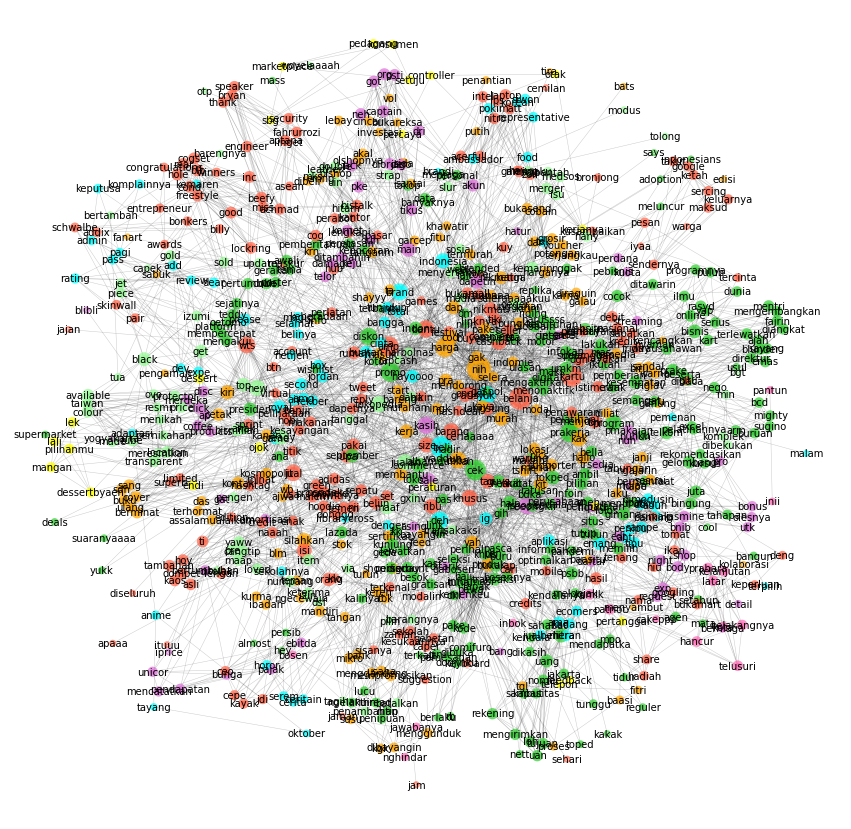

In [402]:
df = create_graph(nodes,edges)

In [404]:
df_semantic.to_csv('semantic.csv',index=False)